<a href="https://colab.research.google.com/github/elizathornton/Wound-Classifier/blob/main/Wound_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wound classification using resnet CNN

This is an attempt to reproduce the work of this excellent paper: https://www.nature.com/articles/s41598-022-21813-0

The dataset is from the AZH Wound and Vascular Center in Milwaukee, Wisconsin. It is published here: https://github.com/uwm-bigdata/Multi-modal-wound-classification-using-images-and-locations/tree/main/dataset

#[Discussion of Clincal Use](#clinical)



In [ ]:
from fastai.vision.all import *
from fastai.metrics import accuracy

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using the easy data learner structure from fast.ai
Fast.ai's lovely and easy to use data learner structure allows us to use minimal code.  https://docs.fast.ai/tutorial.vision.html

In [ ]:
#the location of the wound files
train_path = '/content/drive/My Drive/Learn/Wounds/data/Train'
test_path = '/content/drive/My Drive/Learn/Wounds/data/Test'


#Create a list of all image file paths within the subfolders:
file_paths = get_image_files(train_path)
test_paths = get_image_files(test_path)

In [ ]:
#Define a function to extract the label from the subfolder name
def get_label(file_path):
    return file_path.parent.name


In [ ]:
# pass the data from the images on my google drive into datablocks that can be used by  fast.ai's data loaders
data_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       get_y=get_label,
                       item_tfms=Resize(224),
                       batch_tfms=aug_transforms())
dls = data_block.dataloaders(train_path)

test_dls = data_block.dataloaders(test_path)


Let's look at a random sample of the images we are working with in the training set:

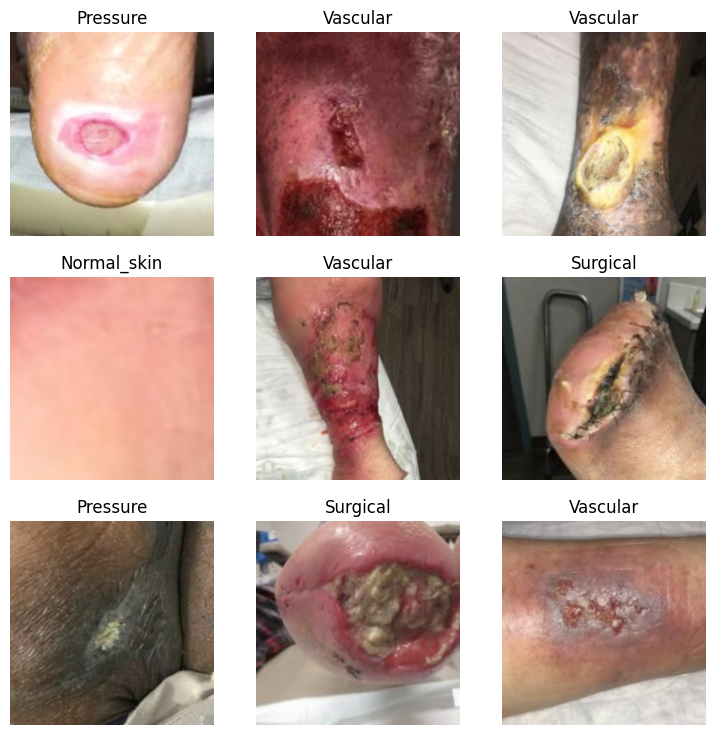

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 56.6MB/s]


SuggestedLRs(valley=0.0008317637839354575)

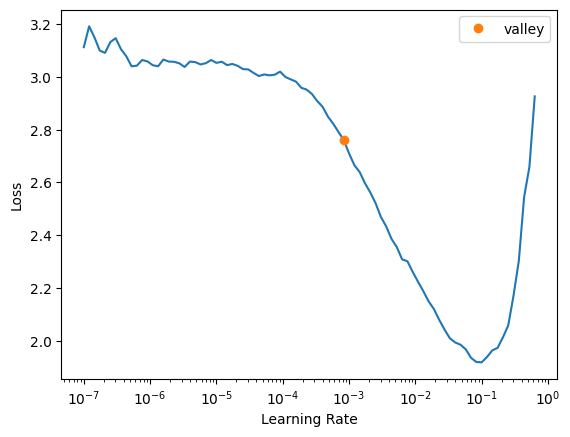

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(8, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.347866,1.473414,0.374101,00:11


epoch,train_loss,valid_loss,error_rate,time
0,1.310397,1.006948,0.316547,00:03
1,1.063957,0.946925,0.266187,00:03
2,0.886502,0.928225,0.266187,00:03
3,0.720492,1.062647,0.251799,00:03
4,0.605712,1.074105,0.258993,00:03
5,0.526955,1.039986,0.258993,00:03
6,0.456528,1.057879,0.251799,00:03
7,0.404568,1.046939,0.251799,00:03


SuggestedLRs(valley=5.248074739938602e-05)

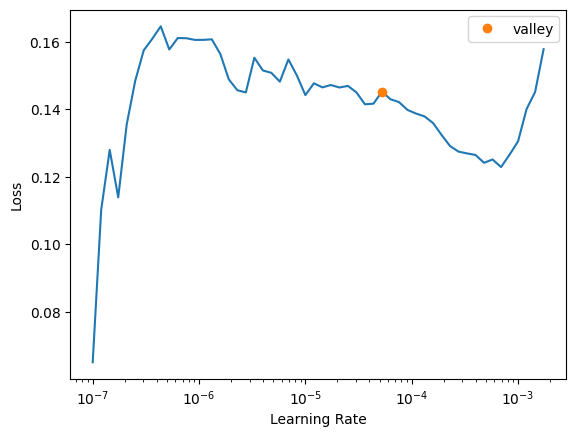

In [ ]:
learn.lr_find()

#Predictions
Let's see how well the classifier works by looking at some images, labels, and predictions.   It's not perfect, but for only 730 images, it's pretty darn good.

In [ ]:

# Calculate accuracy on the validation set
acc = accuracy(*learn.get_preds())

# Print accuracy
print(f"Accuracy: {acc.item()}")

Accuracy: 0.7482014298439026


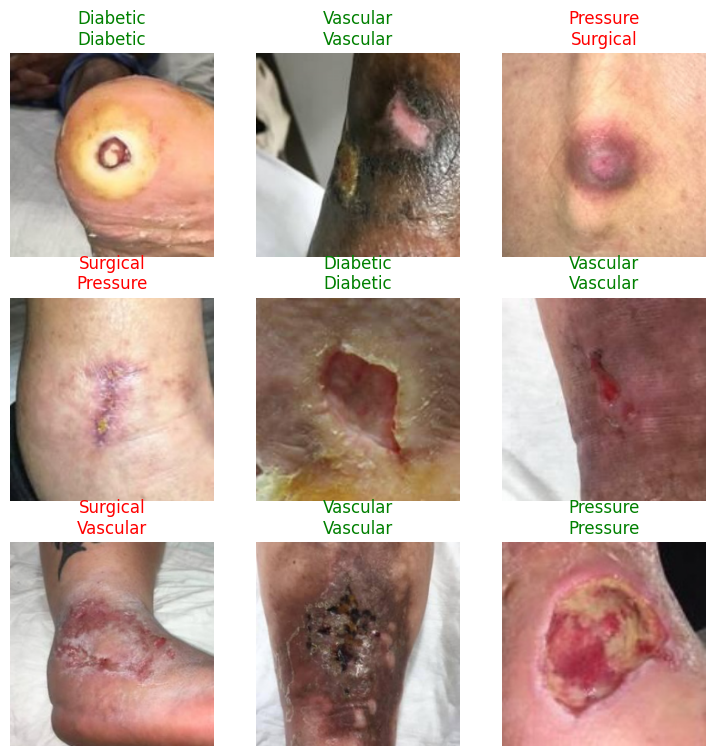

In [ ]:
learn.show_results()

In [ ]:
interp = Interpretation.from_learner(learn)

# Edge Cases
Let's look at cases where the model had trouble predicting

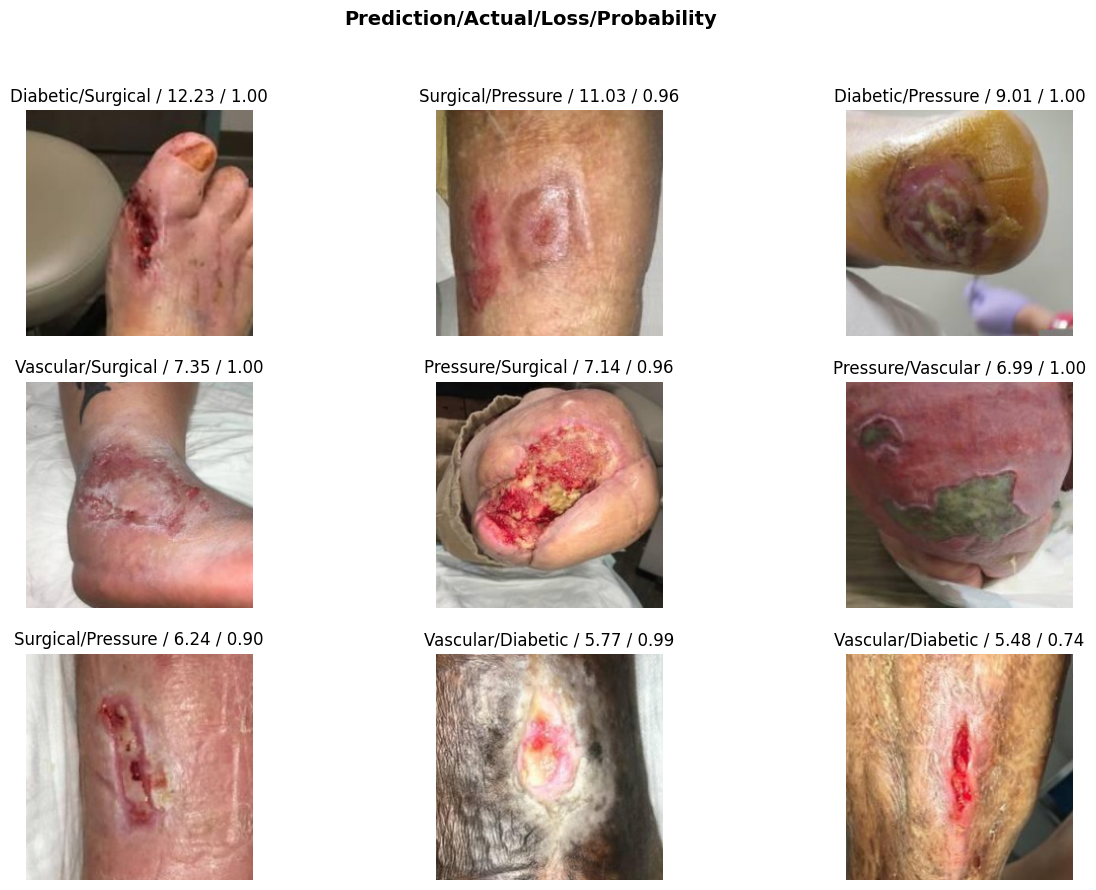

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))

<a id='clincal'></a>
#Clinical Use
<sub>*Summary:*<sub>
- <sub>*Use it in EHRs to suggest coding*<sub>
- <sub>*Use it to populate clinical reminders*<sub>
- <sub>*Use it in direct-to-patients apps* <sub>





##What clinical good is wound classification?
Having a AI model for wound classification would be an incredible tool. I'd like to explore its potential benefits in clinical practice while also considering possible limitations.

###Limitations
To enhance a clinical practice, software should outperform clinicians in specific tasks while seamlessly integrating into their workflow without added complexity.
Merely using a wound classifier to label a wound has limited clinical usefulness. Most clinicians are competent to identify the underlying pathology of a wound. Even when uncertain, clinicians often rely on patient history to make more accurate assessments rather than solely relying on an image interpretation by a wound classifier. In reality, most wounds exist on a spectrum, such as diabetic wounds that coexist as pressure ulcers or vascular wounds displaying both venous and arterial insufficiency.

Can the classifier be helpful in guiding treatment?  Perhaps. The main question in treatment choice is often not "What is recommended?" but "What is covered by insurance?"  Fortunately, for any given wound there are usually many possible successful wound care protocols.  The basic principles of dressing a wound apply to wounds of all origins:
- Keep it moist
- But not too moist
- Keep it clean  
- Get rid of dead tissue
- Keep the pressure off
- Nutrition!

Most clinicians who see wounds on a regular basis have a few favorite "go-to" dressing regimens that they try first.  I think that is unlikely to be changed by a classifier.  However, a classifier combined with a formulary search tool could present options and help in ordering wound care supplies.

##So how can this technology fit into practice?
Providers don't really need help with know what a wound is or how to treat it.
What providers **DO** need help with is the overwhelming amount of adminstrative burden involved in care.  At its best, health tech should lessen that burden and smooth the path for clinicians to focus on the patient and clinical decision making.  The administrative burdens involved in wound care are:
- Coding
- Documentation
- Ordering wound care supplies
- Care gaps


##Coding:

Let's start with coding, since coding is the area where a wound classifier could really shine.

There are hundreds of ICD 10 codes for wounds.  Imagine a typical older patient: 75 year old female obese, diabetic, smoker, with peripheral vascular disease.  Imagine she has developed a sore on the outside of her left foot, reaching from the side of the heel to just below the ankle.   Here are a few valid ways you could code that:
- L89.529 Pressure ulcer of left ankle, unspecified stage
- L89. 622 Pressure ulcer of left heel, stage 2
- E11. 621 for Type 2 diabetes mellitus with foot ulcer

A trained medical coder could read that description and tell you that it should be coded as specifically as possible, that you should code any ischemia in the wound first, and that you should exclude infected or diabetic wounds from a pressure ulcer coding.  However, clinicians have limited time to decide on the appropriate code during a short visit. Complicating matters, each ICD-10 code has numerous descriptors, resulting in a long list when searching in the EMR software.

**How a classifier could assist:** By understanding ICD-10 rules, a classifier could suggest the most probable code as the default choice, which clinicians can accept if in agreement.



###Documentation:
Solutions are already developed for smoothing documentation.  Epic app orchard (for the the 30% of doctors in the US who are on Epic) has a few apps which use an image of a wound to automatically populate the note with measurements and save the image to the chart.  Outside Epic, products such as this: https://www.tissue-analytics.com/  are popping up which can also do wound measurement (and probably much more accurately than humans).   At this point, getting these tools into daily use for all the interactions where wounds are being treated across the country is a problem for implementation science:  https://www.sciencedirect.com/science/article/pii/S016517811930602X




##Ordering wound care supplies:
Wound care supplies are obtained from DME (durable medical equipment) companies and billed to the patient's insurance. Documentation is crucial for the DME companies to process the insurance claims, requiring a clinical note, an order, and wound measurements. Most DME companies not only request the visit note but also their own form, which must be completed and signed by the provider. Sometimes, the DME company conveniently pre-fills the form with the ordered items, providing a single line for the provider's signature and date. However, less fortunate instances involve receiving a densely printed, small-font form with numerous options, necessitating a search for spaces to enter wound measurements and sign. These form-filling tasks involve retrieving the patient's last visit note and locating the relevant measurements. While each task may only take a few minutes, the cumulative effect of performing these repetitive data entry tasks throughout the day consumes a significant amount of clinician's time.

There is already intelligent fax handling technology available that can read PDFs and enter pre-filled information. Implementing this technology and establishing connections between EMRs and PDF handling tools would be more suitable for this task rather than relying solely on a classifier. However, a classifier could be integrated into ordering software to automatically populate the necessary information for DME companies.


##Care gaps:
Care gaps are the appropriate "To Do" list for patients based on their diagnoses.  For instance, a patient with a potentially ischemic wound should undergo arterial dopplers and be referred to vascular for potential artery stenting to restore blood flow to the leg. A patient with a diabetic ulcer should receive diabetic education and medication adjustments to achieve a target HA1C range. Clinicians are aware of these necessary steps, but in reality, limited time, resources, and patient/family cooperation can make achieving them challenging amidst chaotic visits.


I work in home care.  My visits to patients with wounds sometimes revolve around the wounds; I am able to provide practical guidance on hygeine, nutrition, and relieving pressure. Other times, urgent matters like poverty, hoarding, family violence, mental health, very poor hygiene, or alcoholism take precedence, pushing the wound to a lower priority. In such cases, it becomes challenging to focus on appropriate follow-up care gaps. To address this, a wound classifier can assist by automatically populating the visit note with reminders based on the wound category. For instance, a diabetic ulcer classification can prompt a reminder to order a CRP and X-ray for potential osteomyelitis evaluation.



#Power to the people
AI and health tech possess power to significantly reduce adverse outcomes across large populations by directly empowering patients and families.

##Preventable wounds
Some wounds happen even in ideal circumstances.  A 102-year-old patient can be lovingly and meticulously cared for, but the skin, like all organs, can just fail.   However, many wounds are worsened by behavioral factors.  As our bodies become more frail, harmful habits can escalate and lead to significant issues. Some habits that contribute to non-healing wounds include prolonged leg-down sitting, smoking, medication non-adherence, wearing ill-fitting shoes, sitting in a wet adult diaper, letting blood sugars get out of control, or indulging in salty foods.   


Intelligent technology has the potential to facilitate behavioral change by empowering patients and caregivers. Imagine a consumer tech app equipped with a wound classifier. A family member could capture an image of a developing wound on their grandma's skin and receive a list of suggestions for improving the wound, complete with convenient Amazon links for products like Juven and wedge pillows. They could monitor the wound's progress by imaging it daily and receive rapid feedback on the effectiveness of their actions. A patient with venous stasis wounds could receive alerts if they sit with their feet down for an extended period. A patient with a diabetic wound could instantly access educational resources explaining the connection between their wound and blood glucose levels.

##Tech as Public Health
Knowledge transitions from research to clinical practice, eventually permeating popular use and becoming ingrained in established culture.   In the 1860's Louis Pasteur was dunking glass vials of milk in boiling water, then a few years later Joseph Lister was making all his students wash their hands with carbolic acid between surgeries.  Today, handwashing after using the bathroom is a common practice, resulting in fewer deaths from cholera and other preventable diseases.


Just yesterday I visited a patient who is developing a vascular wound on his leg.  He found it almost impossible to believe that the wound was a result of the smoking, and attempted education occupied most of our visit.  My hope is that knowledge that right now lives in the realm of health care can soon be common knowlege, and even more importantly, common **practice**.
I can imagine a future where a wound classifier is integrated into comprehensive health technology, monitoring and evaluating all aspects of well-being, providing education, behavioral interventions, prompt feedback, and guidance.

